# Multi-Class n-Pair Loss

In [1]:
from pathlib import Path

METRICS_FILEPATH = "metrics.json"

MODEL_DIR = "models"
FIG_DIR = "figures"

# Create output directories if not exist
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)
Path(FIG_DIR).mkdir(parents=True, exist_ok=True)

### The "Hard Class"-Problem

Up until now our contrastive models have done fairly well when it comes to predicting the similarity between two samples, but have struggled when applied in a classification setting. How can this be?

One plausible intuition.

Assume we have 10 different classes, each with one reference and one sample.
For each reference we choose 2 pairs:

1. The matching sample
2. A random non matching sample

We are therefore left with 20 pairs.

Let's consider only one of our 10 classes to be "hard". In our data we are guaranteed one matching and one non matching pair involving the hard class. Since the chance to draw a given class when choosing the random non-matching class is 1/9 and we draw 9 random samples for the easy classes, we'll assume our data contains one more non matching pair involving the hard class.

Let's also assume our model will always predict an extremely small distance for a pair whenever the hard class is involved.
The model can also be assumed to predict "perfect" distances for pairs of the 9 easy classes (as long as the hard class is not involved).

We ask our model to make predictions on the 20 pairs, the result will always be:

- Perfect distances for the 17 easy pairs (17 true positives)
- "Perfect" distance for the 1 matching hard pair (1 true positive)
- Incorrect distance for the 2 non-matching hard pairs (2 false positives)

This would result in an accuracy score of $\frac{TP+TN}{TP+FP+TN+FN} = \frac{18}{20} = 0.9$. Amazing!

Now let's think about the classification setting:

We will now ask the model to compare each of our 20 samples to each of our 20 references, the reference producing the smallest distance to the given sample will be assumed to be the predicted class.

This however means, that every sample will also be compared to the hard class, in which case the model will predict a very minimal distance. (We can assume this distance is always smaller than all other predicted distances.)

Our model's classification predictions will therefore always look like this:

- 1 correct prediction (hard class)
- 19 incorrect predictions (easy class)

This will result in an accuracy score of $\frac{1}{20} = 0.05$.

If we compare this theoretical scenario to our models' confusion matrices, we'll see it doesn't hold true entirely, but we can observe a very similar pattern for the two hard "u" and "v" classes.

Overall we can get an intuition for how a model's inability to differentiate between a few hard classes can still allow it to achieve great accuracy for pair-wise distances, but make it struggle in classification settings.

## Multi-Class n-Pair Loss

If the hard pairings are underrepresented in out training data our model can "get away" with performing badly on them, since the punishment for doing so is minimal.

A possible solution for this would be hard negative mining, but as we saw with our implementation of Triplet Loss its effect was fairly limited.

Another possible solution would be the use of Multi-Class n-Pair Loss:

What if, instead of only comparing pairs or triplets, we could compare a positive sample to a much wider range of negative samples, e.g. a metric close to categorical cross entropy but using a distance metric?

$$ L_{N-pair-mc}(\{(x_i, x_i^+ )\}_{i=1}^N; f ) = \frac{1}{N} \sum^{N}_{i=1} log(1+ \sum_{j \neq i} exp(f^T_i f^+_j - f^T_i f^+_i))$$

To avoid excessive computation, Multi-Class n-Pair Loss usually employs a special batch construction method:

Let ${(x_1, x^+_1 ), · · · , (x_N , x^+_N )}$ be $N$ pairs of examples from $N$ different classes, i.e., $y_i \neq y_j, ∀i \neq j$.

We build $N$ tuplets, denoted as $\{S_i\}^N_{i=1}$, from the $N$ pairs, where $S_i = \{x_i, x^+_1 , x^+_2 , ··· , x^+_N\}$.

Here, $x_i$ is the query for $S_i$, $x^+_i$ is the positive example and $x^+_j$ , $j \neq i$ are the negative examples.

Or in other words:

Assuming our data consists of $N$ classes each batch is dedicated to one sample of our dataset containing the sample itself, one matching sample, as well as one non-matching sample for each of our $N-1$ other classes.

Lets try constructing a training dataset using this batch construction method:

In [2]:
import random
import numpy as np
import numpy.typing as npt
from keras.utils import Sequence
from sklearn.utils import shuffle

class NPairDataGen(Sequence):
    """Custom data generator.
    
    Reference:
        https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3
    """

    x: npt.NDArray[np.float32]
    y: npt.NDArray[int]
    unique_labels: npt.NDArray[int]
    num_classes: int
    num_samples_per_class: int
    
    def __init__(
        self,
        x: npt.NDArray[np.float32],
        y_numeric: npt.NDArray[int]
    ):
        self.x = x.copy()
        self.y = y_numeric.copy()

        # Sort samples by label (in case they were shuffled)
        sort_idx = np.argsort(self.y)
        self.x = self.x[sort_idx]
        self.y = self.y[sort_idx]

        # Determine the class with the least amount of samples
        self.unique_labels, counts = np.unique(self.y, return_counts=True)
        self.num_classes = len(self.unique_labels)
        min_count = np.min(counts)

        # Reduce label count for each class to min amount of samples
        reduced_y = np.repeat(self.unique_labels, min_count)
        
        # Pick the data according to the reduced labels
        reduced_x: list[npt.NDArray[np.float32]] = []
        for label in self.unique_labels:
            indices = np.where(self.y == label)[0][:min_count]
            reduced_x.extend(list(self.x[indices]))

        self.y = reduced_y
        self.x = np.array(reduced_x)
        self.num_samples_per_class = min_count

    def on_epoch_end(self):
        pass

    def __get_random_matching_index(self, y: int, Y: npt.NDArray[int]) -> int:
        matching_indices = np.where(Y == y)[0]
        matching_idx = random.choice(matching_indices)
        assert Y[matching_idx] == y
        return matching_idx
    
    def __getitem__(self, batch_index: int) -> tuple[npt.NDArray[np.float32], npt.NDArray[int]]:
        """Get n-Pair batch."""
        X_anchor = self.x[batch_index::self.num_samples_per_class]
        Y_anchor = self.y[batch_index::self.num_samples_per_class]
        X_anchor, Y_anchor = shuffle(X_anchor, Y_anchor)

        # Get random positive sample for each anchor
        X_positive = np.array(
            [self.x[self.__get_random_matching_index(y, self.y)] for y in Y_anchor]
        )

        return (
            [X_anchor, X_positive],
            Y_anchor,
        )

    
    def __len__(self):
        return self.num_samples_per_class

In [3]:
from sklearn.model_selection import train_test_split
from core.dataset import DGSAlphabet

TEST_LABELS = ['u', 'v', 'w', 'x', 'y']

# Import the dataset
dataset = DGSAlphabet()
categorical_dataset = dataset.load_categorical_numeric(
    exclusive_test_labels=TEST_LABELS
)
x_train_val = categorical_dataset.x_train
y_train_val = categorical_dataset.y_train
x_test = categorical_dataset.x_test
y_test = categorical_dataset.y_test
label_map = categorical_dataset.label_map

x_train, x_val, y_train, y_val = train_test_split(
    x_train_val,
    y_train_val,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

Our generated batch now looks like the description in the paper:

In [4]:
train_gen = NPairDataGen(x_train, y_train)

x_batch, y_batch = train_gen.__getitem__(0)
y_batch

array([ 2, 17, 16,  8, 10,  4,  7,  6, 15, 13,  0,  3, 14,  5, 18,  9, 11,
       12,  1])

In [5]:
# Same for validation data
val_gen = NPairDataGen(x_val, y_val)

We'll also be generating one batch for the minimum amount of samples per class, just like we would expect:

In [6]:
print(x_train.shape[0], train_gen.__len__())

4576 209


We'll adapt the TFA implementation of `npairs_loss`:

In [7]:
import tensorflow as tf
from tensorflow_addons.losses import npairs_loss

def npair_loss(y_true: tf.Tensor, embeddings: tf.Tensor):
    """N-Pair Loss for batch for anchor and positive embeddings.ipynb
    
    Reference:
        https://www.tensorflow.org/addons/api_docs/python/tfa/losses/npairs_loss
    """
    e_anchor = embeddings[0]
    e_positive = embeddings[1]
    y_pred = tf.matmul(e_anchor, e_positive, transpose_a=False, transpose_b=True)
    return npairs_loss(y_true, y_pred)
    

/Users/moritz/Documents/Hochschule Augsburg/Semester 2 - Master/Data Science/project/venv/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Let's instantiate our model as a Siamese Neural Network, but exclude the merge (distance) layer (-> output 2 embeddings).

Interestingly, our model is very sensitive to Batch Normalization: Not including any Batch Normalization causes our model to collapse after ~2 epochs, outputting only constant values as predictions. Adding additional Batch Normalization after the embedding layer boosts the model's validation accuracy by ~0.1.

In [8]:
from core.util import new_SNN_builder

# Create model builder for Keras Tuner
build_model = new_SNN_builder(
    mode="siamese",
    loss=npair_loss,
    distance=None,
    siamese_sigmoid_output=False,
    force_embedding_bn=True
)

In [9]:
# Tuning Hyperparameters
# https://keras.io/api/keras_tuner/tuners/hyperband
MAX_EPOCHS = 150
FACTOR = 3
HYPERBAND_ITERATIONS = 1
SEED = 42

# Where to save tuner checkpoints
TUNER_DIR = "tuner"
PROJECT = "npair_loss"

In [10]:
import keras_tuner

tuner = keras_tuner.Hyperband(
    hypermodel=build_model,
    objective="val_loss",
    max_epochs=MAX_EPOCHS,
    factor=FACTOR,
    hyperband_iterations=HYPERBAND_ITERATIONS,
    seed=SEED,
    directory=TUNER_DIR,
    project_name=PROJECT
)

tuner.search_space_summary()

Reloading Tuner from tuner/npair_loss/tuner0.json
Search space summary
Default search space size: 7
dense_count (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 2, 'sampling': 'linear'}
dense_base (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 8, 'sampling': 'linear'}
encoder_dropout (Boolean)
{'default': False, 'conditions': []}
start_lr (Float)
{'default': 5e-05, 'conditions': [], 'min_value': 5e-05, 'max_value': 0.001, 'step': 5e-05, 'sampling': 'linear'}
beta_1 (Float)
{'default': 0.7, 'conditions': [], 'min_value': 0.7, 'max_value': 0.9, 'step': 0.1, 'sampling': 'linear'}
beta_2 (Float)
{'default': 0.99, 'conditions': [], 'min_value': 0.99, 'max_value': 0.999, 'step': 0.001, 'sampling': 'linear'}
epsilon (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': 0.001, 'sampling': 'linear'}


We'll use the same callbacks as for the classification training.

In [11]:
from core.util import new_default_callbacks, TunerHistoryCallback

# Reduce learning rate if no improvement is made
reduce_lr, early_stop = new_default_callbacks(
    monitor="val_loss",
    mode="min",
    lr_reduce_factor=0.2,
    lr_reduce_patience=5,
    verbose=1
)

# Keep track of histories for every tuner trial
tuner_history_cb = TunerHistoryCallback(tuner)

Loading history from JSON tuner/npair_loss/history.json


Notice that we are not defining a batch size, our data generator will handle this implicitly.

In [12]:
tuner.search(
    train_gen,
    validation_data=val_gen,
    callbacks=[reduce_lr, early_stop, tuner_history_cb]
)

In [13]:
tuner.results_summary()

Results summary
Results in tuner/npair_loss
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0200 summary
Hyperparameters:
dense_count: 6
dense_base: 48
encoder_dropout: False
start_lr: 0.0008
beta_1: 0.7
beta_2: 0.999
epsilon: 0.007
tuner/epochs: 150
tuner/initial_epoch: 50
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0199
Score: 0.09478799253702164

Trial 0237 summary
Hyperparameters:
dense_count: 6
dense_base: 8
encoder_dropout: False
start_lr: 0.0008
beta_1: 0.7999999999999999
beta_2: 0.998
epsilon: 0.007
tuner/epochs: 150
tuner/initial_epoch: 50
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0231
Score: 0.11346976459026337

Trial 0199 summary
Hyperparameters:
dense_count: 6
dense_base: 48
encoder_dropout: False
start_lr: 0.0008
beta_1: 0.7
beta_2: 0.999
epsilon: 0.007
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0184
Score: 0.12179848551750183

Trial 0201 summary
Hyperparameters:
dense_count: 6
dense_base: 8


Since we want convenient access to the model's encoder part, we'll re-instantiate the model with the best architecture and transfer the best model's weights:

In [14]:
# Get history of best model training
best_trial = tuner.oracle.get_best_trials(1)[0]
best_model_history = tuner_history_cb.get_trial_history(
    best_trial.trial_id
)

# Get weights of best model
best_model = tuner.get_best_models(1)[0]
best_weights = best_model.weights

# Re-create best architecture
best_hyper_params = tuner.get_best_hyperparameters(1)[0]
snn_encoder, siamese_snn = build_model(best_hyper_params, get_encoder=True)
siamese_snn.set_weights(best_weights)

siamese_snn.summary()

Model: "SNN_6_siamese"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 21, 3)]              0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 21, 3)]              0         []                            
                                                                                                  
 SNN_6_encoder (Functional)  (None, 48)                   3532374   ['input_3[0][0]',             
                                                                     'input_4[0][0]']             
                                                                                                  
 lambda_1 (Lambda)           (2, None, 48)                0         ['SNN_6_encoder[0]

Let's save the best model and take a look at its training history:

In [15]:
siamese_snn.save(f"{MODEL_DIR}/npair_loss.keras")

We can notice our validation accuracy is quite a bit lower than with previous training methods, struggling to push above 0.8:

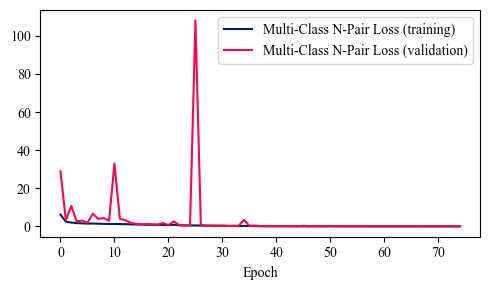

In [16]:
from core.viz import visualize_history

visualize_history(
    best_model_history,
    ["loss"],
    "Multi-Class N-Pair Loss",
    f"{FIG_DIR}/npair_loss_history.svg"
)

But we were mainly worried about improving our accuracy on unseen test data in a classification scenario. Conveniently, our n-Pair Loss is equivalent to Categorical Crossentropy, since our batch size equals the number of classes.

This allows use to use the builtin evaluate method for a classification-like evaluation.

While our accuracy is still significantly lower than using other losses, it is very similar to our validation acuracy (only ~3% deviation), something we were unable to achieve before.

In [17]:
test_gen = NPairDataGen(x_test, y_test)

In [18]:
loss = siamese_snn.evaluate(test_gen, verbose=0)
print(f'++++++++++++ Test data ++++++++++++\nloss={loss:.4f}')

++++++++++++ Test data ++++++++++++
loss=0.8390


In [19]:
from keras.models import Model

def npair_predict(model: Model, test_gen: NPairDataGen):
    """Run prediction on NPair Generator and format as integer (y_true, y_pred)."""
    preds = model.predict(test_gen)
    preds = preds.reshape((-1, 2, 5, model.output.shape[-1]))

    Y_pred: list[int] = []
    Y_true: list[int] = []

    for i, pred in enumerate(preds):
        e_anchor = pred[0]
        e_positive = pred[1]
        y_pred = np.matmul(e_anchor, e_positive.T)
        _, y_true = test_gen[i]
        y_true = np.expand_dims(y_true, axis=-1)
        y_true = np.equal(y_true, y_true.T).astype(y_pred.dtype)

        y_true = np.argmax(y_true, axis=-1)
        y_pred = np.argmax(y_pred, axis=-1)
        
        Y_pred.extend(list(y_pred))
        Y_true.extend(list(y_true))
    
    return (Y_true, Y_pred)

In [20]:
y_true, y_pred = npair_predict(siamese_snn, test_gen)

305/305 [==============================] - 1s 3ms/step


Looking at the confusion matrix, we can see our model's incorrect predictions are a lot more evenly distributed. No more significantly better or wore classes!

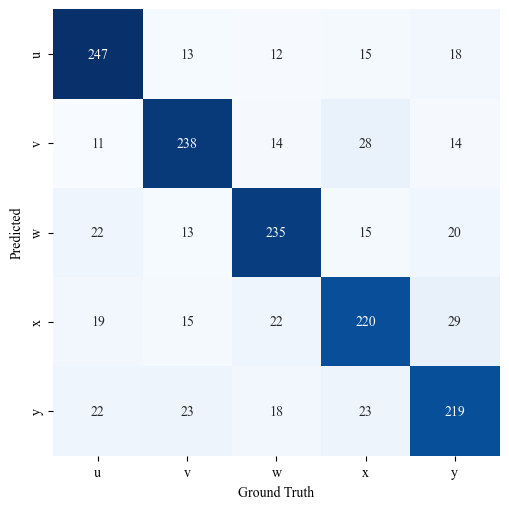

In [21]:
from core.viz import visualize_confusion_matrix

unique_test_labels = list(set(y_test))
reverse_label_map = {int_lbl: str_lbl for str_lbl, int_lbl in label_map.items()}
str_test_labels = [reverse_label_map[lbl] for lbl in unique_test_labels]

visualize_confusion_matrix(
    y_true, y_pred,
    str_test_labels,
    f"{FIG_DIR}/npair_loss_conf_matrix_naive.svg"
)

In [22]:
categorical_dataset = dataset.load_categorical_numeric(
    exclusive_test_labels=TEST_LABELS
)

x_test = categorical_dataset.x_test
y_test = categorical_dataset.y_test
label_map = categorical_dataset.label_map

In [23]:
from core.util import evaluate_n_way_accuracy


y_true, y_pred, mean_acc, min_acc, max_acc, std = evaluate_n_way_accuracy(
    x_test,
    y_test,
    snn_encoder,
    k_prototype=1,
    iterations=10
)

print(
    f"Mean 5-way accuracy: {mean_acc}\n"
    f"Min 5-way accuracy: {min_acc}\n"
    f"Max 5-way accuracy: {max_acc}\n"
    f"5-way accuracy std.: {std}"
)

Mean 5-way accuracy: 0.6881012658227849
Min 5-way accuracy: 0.5164556962025316
Max 5-way accuracy: 0.8107594936708861
5-way accuracy std.: 0.09170787797256248


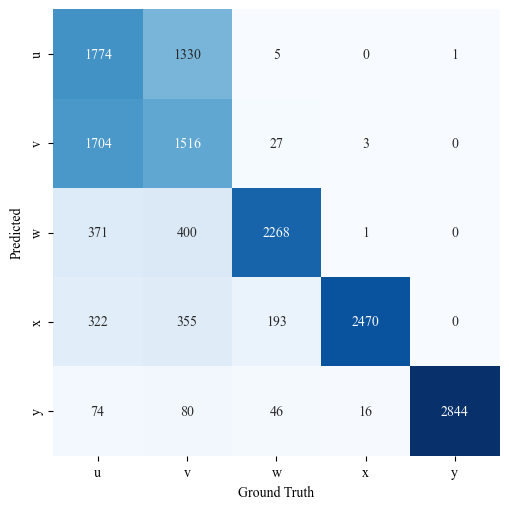

In [24]:
unique_test_labels = list(set(y_test))
reverse_label_map = {int_lbl: str_lbl for str_lbl, int_lbl in label_map.items()}
str_test_labels = [reverse_label_map[lbl] for lbl in unique_test_labels]

visualize_confusion_matrix(
    y_true, y_pred,
    str_test_labels,
    f"{FIG_DIR}/npair_loss_conf_matrix.svg"
)

In [25]:
from core.util import save_n_way_k_prototype_accuracy

save_n_way_k_prototype_accuracy(
    x_test,
    y_test,
    snn_encoder,
    METRICS_FILEPATH,
    "Multi-Class N-Pair Loss"
)

Mean 5-way accuracy (k-prototype = 1): 0.6881012658227849, std: 0.09170787797256248
Mean 5-way accuracy (k-prototype = 3): 0.7623566878980893, std: 0.04683105588220703
Mean 5-way accuracy (k-prototype = 5): 0.7905769230769232, std: 0.03675939726533856
Mean 5-way accuracy (k-prototype = 10): 0.8099674267100976, std: 0.02482255673062977
Mean 5-way accuracy (k-prototype = 15): 0.8010596026490064, std: 0.020043809743198374
Mean 5-way accuracy (k-prototype = 20): 0.8119191919191919, std: 0.01721339103665997
Mean 5-way accuracy (k-prototype = 50): 0.809812734082397, std: 0.009659436702926037
Mean 5-way accuracy (k-prototype = 75): 0.8126446280991736, std: 0.013098847663907667
Mean 5-way accuracy (k-prototype = 100): 0.812995391705069, std: 0.009412209722487828
Saved Multi-Class N-Pair Loss metrics to metrics.json


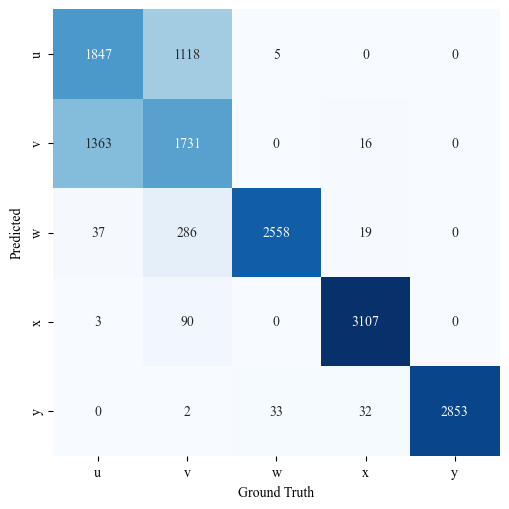

In [26]:
y_true, y_pred, _, _, _, _ = evaluate_n_way_accuracy(
    x_test,
    y_test,
    snn_encoder,
    k_prototype=15,
    iterations=10
)

visualize_confusion_matrix(
    y_true, y_pred,
    str_test_labels,
    f"{FIG_DIR}/npair_loss_conf_matrix_k15.svg"
)

In [27]:
# And get embeddings for the test data
embeddings = snn_encoder.predict(x_test)

50/50 [==============================] - 0s 3ms/step


In [28]:
from sklearn.manifold import TSNE

# Fit T-SNE on embeddings
tsne = TSNE(n_components=2, random_state=42, verbose=1)
reduced_embeddings = tsne.fit_transform(embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1585 samples in 0.000s...
[t-SNE] Computed neighbors for 1585 samples in 0.319s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1585
[t-SNE] Computed conditional probabilities for sample 1585 / 1585
[t-SNE] Mean sigma: 3.048883
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.875130
[t-SNE] KL divergence after 1000 iterations: 0.413897


Interestingly, the dimension-reduced embeddings still show a significant overlap for the "u" and "v" classes. This is especially confusing, because our model features no non-linear layers past the embedding layer.

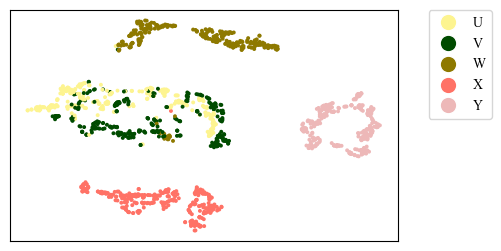

In [29]:
from core.viz import visualize_embeddings

# Visualize embeddings in scatter plot
visualize_embeddings(
    reduced_embeddings,
    y_test,
    label_map,
    f"{FIG_DIR}/npair_loss_embeddings.svg"
)